#### The task is to predict flow rate of P1, P2 within 3 upcoming steps of simulation. Forecasting may be targeting oil or liquid. <br>([Link for the descriptive task formulation ](https://voskresenskiianton.notion.site/Home-task-2-intern-data-scientist-Aramco-Inn-025d9726498d400aa3f27774739473b5))

# Introductory analysis (this refers to the notebook that was given in the task as a starting point)

When the `I3` well was activated during the 19th timestep, the oil production rates (`oil`) of `P1` & `P2` began to increase. This can be attributed to the injection of water by the `I3` well into the reservoir, which supports the reservoir pressure. As a result, the reservoir pressure increases and enhances the force that drives the fluid out of the reservoir.

Furthermore, the bottomhole pressure (`bhp`) of the wells `I1` & `I2` began to increase after `I3` activation during the 19th timestep. This can be attributed to the water injection by the `I3` well into the reservoir, which supports the reservoir pressure and helps maintain the `bhp`.

# Let's start coding

In [ ]:
# Uncomment if needed

!pip install darts

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display

In [ ]:
# load data
EXPERIMENT_LENGTH = 30

path = "data.csv"
df = pd.read_csv(path)
df.head()

,cat,group,date,oil,water,liquid,bhp,status,start_lag,coef
0,P1,P,0,-0.001486,0.000000,-0.001486,2.000000e+07,1,19,0.42
1,P2,P,0,-0.001941,0.000000,-0.001941,2.000000e+07,1,19,0.42
2,I1,I,0,NaN,0.002550,0.002550,4.031142e+07,1,19,0.42
3,I2,I,0,NaN,0.001275,0.001275,3.568871e+07,1,19,0.42
4,I3,I,0,NaN,NaN,NaN,NaN,0,19,0.42


Text(0.5, 1.0, 'Oil production for all experiments')

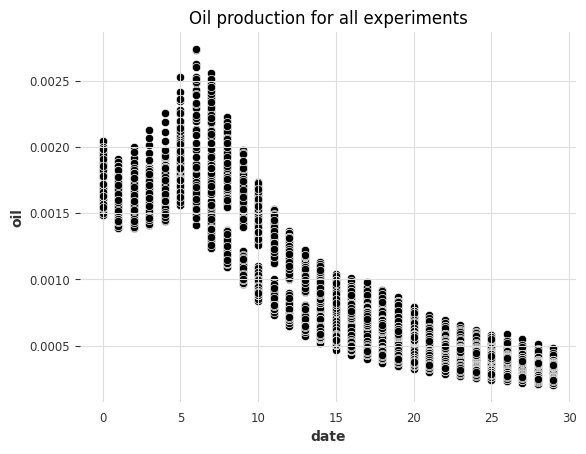

In [ ]:
sns.scatterplot(df, x = df.date, y = np.abs(df.oil)).set_title('Oil production for all experiments')

# Preprocessing

In [ ]:
df = df.set_index(df.date).drop('date', axis=1)

## Changing the type of dataframe, to proper tabular data suitable for ML models

In [ ]:
from tqdm import tqdm_notebook as tqdm

def convert_df(df):
    def get_col_name(col_name, cat_name):
        return f'{col_name}_{cat_name}'

    def modify_row(wide_row, row, well_type, index):
        """
        Create a wide row that encapsulates all types, waiting for input a pd.Series row and a well_type 
        from a list ['P1', 'P2', 'I1', 'I2', 'I3'], as well as index as timestamp
        """
        if wide_row is None:
            wide_row = pd.DataFrame(columns=new_cols, index=pd.Index([index]))
        
        
        # row = row.copy()
        well_cols = [get_col_name(col, well_type) for col in cols]
        row = row.drop(labels=['cat'])
        
        for column_name, value in row.items():
            categorised_col = get_col_name(column_name, well_type) 
            wide_row[categorised_col] = value
        return wide_row
    
    
    
    cols = set(df.columns) - set(['cat'])
    cats = ['P1', 'P2', 'I1', 'I2', 'I3']
    new_cols = [(get_col_name(col, cat)) for cat in cats for col in cols]
    wide_df = pd.DataFrame(columns=new_cols)
    
    wide_row = None
    i_prev = 0
    for i, row in tqdm( df.iterrows() , total=df.shape[0]):
        # if step of simulation changed write row
        if i_prev != i:
            wide_df = pd.concat([wide_df, wide_row], ignore_index = False)
            wide_row = None
        i_prev = i
        
        # the problem is that there are n*5 iterations, but we need only n rows
        wide_row = modify_row(wide_row, row, well_type=row['cat'], index=i)
        
    return wide_df   

### Save data for easier workflow

In [ ]:
wide_df_buff = convert_df(df)
assert len(wide_df_buff.columns) == (len(df.columns) - 1) * 5

<ipython-input-117-3e444df1c2ef>:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, row in tqdm( df.iterrows() , total=df.shape[0]):


  0%|          | 0/20400 [00:00<?, ?it/s]

In [ ]:
wide_df = wide_df_buff.copy()
wide_df.sample(5)

,group_P1,oil_P1,status_P1,liquid_P1,start_lag_P1,coef_P1,bhp_P1,water_P1,group_P2,oil_P2,...,bhp_I2,water_I2,group_I3,oil_I3,status_I3,liquid_I3,start_lag_I3,coef_I3,bhp_I3,water_I3
12,P,-0.001206,1,-0.002164,8,0.25,20000000.0,-0.000958,P,-0.000747,...,3.588293e+07,0.001271,I,NaN,1,0.000953,8,0.25,3.611638e+07,0.000953
8,P,-0.001623,1,-0.001709,15,0.50,20000000.0,-0.000086,P,-0.001135,...,3.667037e+07,0.001272,I,NaN,0,NaN,15,0.50,NaN,NaN
8,P,-0.001586,1,-0.001694,21,0.33,20000000.0,-0.000108,P,-0.001162,...,3.695818e+07,0.001271,I,NaN,0,NaN,21,0.33,NaN,NaN
25,P,-0.000439,1,-0.002144,2,0.17,20000000.0,-0.001705,P,-0.000254,...,3.052337e+07,0.001270,I,NaN,1,0.000635,2,0.17,2.976701e+07,0.000635
20,P,-0.000580,1,-0.002426,6,0.42,20000000.0,-0.001846,P,-0.000367,...,3.311217e+07,0.001272,I,NaN,1,0.001590,6,0.42,3.491052e+07,0.001590


In [ ]:
# Analyze nan values
nullity_df = (wide_df_buff.isnull().mean() * 100)
nullity_df[nullity_df != 0]

oil_I1       100.000000
oil_I2       100.000000
oil_I3       100.000000
liquid_I3     41.995587
bhp_I3        41.995587
water_I3      41.995587
dtype: float64

In [ ]:
# Fill nan with means
wide_df = wide_df.fillna(0)

# Convert types to int
wide_df = wide_df.convert_dtypes()

# create start_lag col
wide_df['start_lag'] = wide_df['start_lag_P1']

# drop unnecessary columns
def collect_column_names(column):
    groups = ['P1', 'P2', 'I1', 'I2', 'I3']
    return [f'{column}_{g}' for g in groups]

def drop_columns(df):
    def collect_column_names(column):
        groups = ['P1', 'P2', 'I1', 'I2', 'I3']
        return [f'{column}_{g}' for g in groups]
    
    df = df.copy()
    columns_to_drop = ['group', 'start_lag', 'status']
    columns_to_drop_all_cats = []
    for col in columns_to_drop:
        columns_with_group_suffix = collect_column_names(col)
        columns_to_drop_all_cats.append(columns_with_group_suffix)
        
    columns_to_drop_all_cats = np.array(columns_to_drop_all_cats).flatten()
    columns_to_drop_all_cats = np.append(columns_to_drop_all_cats, ['bhp_P1', 'bhp_P2'])
    return df.drop(columns_to_drop_all_cats, axis=1)

wide_df = drop_columns(wide_df)

def fix_unfinished_experiment(df):
    last_row = df.iloc[-1:]
    init_len = len(df)
    columns = df.columns
    
    print('initial_len:', init_len)

    last_idx = last_row.index[-1]
    last_row_copies_needed = EXPERIMENT_LENGTH - (last_idx + 1)
    indexes = list( range(last_idx + 1, 30) )

    
    last_row_x_times = pd.DataFrame(np.repeat(last_row.values, \
                                              repeats = last_row_copies_needed \
                                              ,axis=0) , columns=columns).set_index(pd.Index(indexes))
                                              
    fixed_df = pd.concat([df, last_row_x_times], axis=0)
    assert len(fixed_df) % EXPERIMENT_LENGTH == 0, 'Длина данных не правильно разделена на эксперименты, эксперимент not fixed'
    
    display.display(fixed_df.tail(5))
    return fixed_df
    

wide_df = fix_unfinished_experiment(wide_df)

initial_len: 4079


,oil_P1,liquid_P1,coef_P1,water_P1,oil_P2,liquid_P2,coef_P2,water_P2,oil_I1,liquid_I1,...,liquid_I2,coef_I2,bhp_I2,water_I2,oil_I3,liquid_I3,coef_I3,bhp_I3,water_I3,start_lag
25,-0.000423,-0.001777,0.08,-0.001354,-0.000284,-0.002375,0.08,-0.00209,0,0.002542,...,0.001271,0.08,30088857.731547,0.001271,0,0.000318,0.08,29124116.309916,0.000318,9
26,-0.000403,-0.001783,0.08,-0.00138,-0.000271,-0.002364,0.08,-0.002093,0,0.002542,...,0.001271,0.08,29918344.201704,0.001271,0,0.000318,0.08,28947607.219312,0.000318,9
27,-0.000385,-0.001789,0.08,-0.001404,-0.000259,-0.002354,0.08,-0.002095,0,0.002542,...,0.001271,0.08,29761625.992333,0.001271,0,0.000318,0.08,28785360.89737,0.000318,9
28,-0.000368,-0.001794,0.08,-0.001425,-0.000248,-0.002345,0.08,-0.002097,0,0.002542,...,0.001271,0.08,29617092.723472,0.001271,0,0.000318,0.08,28635723.331819,0.000318,9
29,-0.000368,-0.001794,0.08,-0.001425,-0.000248,-0.002345,0.08,-0.002097,0,0.002542,...,0.001271,0.08,29617092.723472,0.001271,0,0.000318,0.08,28635723.331819,0.000318,9


In [ ]:
wide_df.sample(3)

,oil_P1,liquid_P1,coef_P1,water_P1,oil_P2,liquid_P2,coef_P2,water_P2,oil_I1,liquid_I1,...,liquid_I2,coef_I2,bhp_I2,water_I2,oil_I3,liquid_I3,coef_I3,bhp_I3,water_I3,start_lag
26,-0.000402,-0.002613,0.42,-0.002211,-0.000244,-0.002808,0.42,-0.002563,0,0.00254,...,0.00127,0.42,31642954.373386,0.00127,0,0.001588,0.42,32516039.751233,0.001588,2
11,-0.00117,-0.001735,0.5,-0.000564,-0.000808,-0.002363,0.5,-0.001555,0,0.002543,...,0.001271,0.5,34757956.833594,0.001271,0,0.0,0.5,0.0,0.0,21
10,-0.001308,-0.001745,0.58,-0.000437,-0.000912,-0.00237,0.58,-0.001458,0,0.002543,...,0.001271,0.58,35508825.199533,0.001271,0,0.0,0.58,0.0,0.0,21


# EDA

In [ ]:
df.describe()

,oil,water,liquid,bhp,status,start_lag,coef
count,8160.000000,18687.000000,18687.000000,1.868700e+04,20400.000000,20400.000000,20400.000000
mean,-0.000924,0.000418,0.000014,2.932745e+07,0.916029,11.647059,0.375000
std,0.000554,0.001781,0.002128,8.737189e+06,0.277350,7.177068,0.191512
min,-0.002742,-0.003566,-0.004109,2.000000e+07,0.000000,0.000000,0.080000
25%,-0.001499,-0.001236,-0.002107,2.000000e+07,1.000000,6.000000,0.230000
50%,-0.000728,0.001268,0.001268,3.159104e+07,1.000000,12.000000,0.375000
75%,-0.000433,0.001912,0.001912,3.682427e+07,1.000000,17.000000,0.520000
max,-0.000203,0.002550,0.002550,5.234377e+07,1.000000,24.000000,0.670000


### seems like there are 17 simulations, not 18

In [ ]:

num_of_experiments = int(len(df) / (5 * 30))
print(num_of_experiments)

136


#### There are high positive correlations between water and liquid. There is a high negative correlation for oil and water, and medium  negative correlation for oil and liquid. While it is obvious that liquid feature is higly correlated with other features due to its nature, there may be some observations noted about water and oil. <br> <br> Seems like the more oil is being extracted from a well, the more water is being injected. Also bhp is high when there is a high water injection rate.

<Axes: >

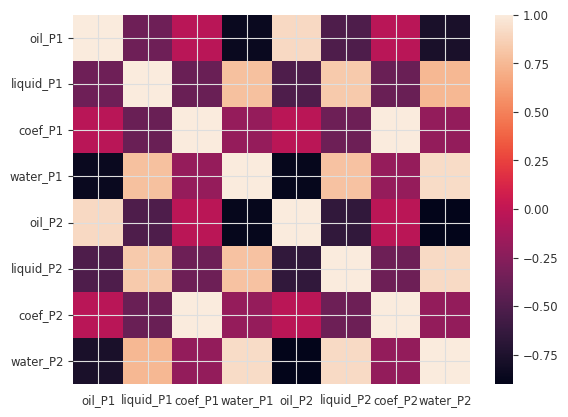

In [ ]:
# Correlations
oil_well_cols = [col for col in wide_df.columns if \
                 col.endswith(('P1', 'P2')) and \
                 not col.startswith(('status', 'bhp')) ]

wide_df = wide_df.convert_dtypes()
sns.heatmap( wide_df[oil_well_cols].corr() )

<Axes: title={'center': '#1 simulation oil production and Start lag'}, xlabel='Time Stamp', ylabel='Oil Production'>

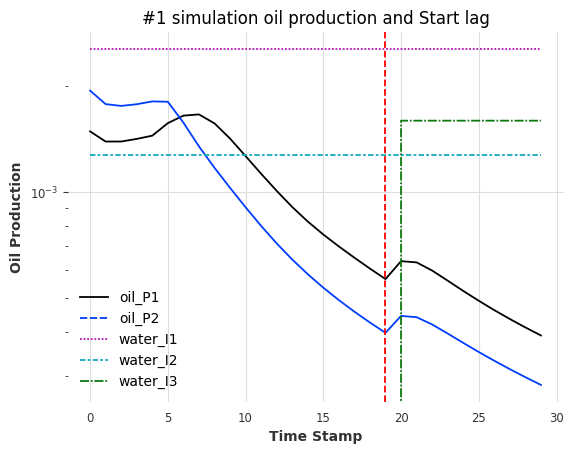

In [ ]:
def plot_simulation(df, num_sim):
    plt.figure()
    right = EXPERIMENT_LENGTH * num_sim
    left = right - EXPERIMENT_LENGTH
    
    sim_df = np.abs(df[left:right])
    
    
    ax = sns.lineplot(data=sim_df[['oil_P1', 'oil_P2', 'water_I1', 'water_I2', 'water_I3']])
    ax.set_title(f'#{num_sim} simulation oil production and Start lag')
    ax.set(xlabel='Time Stamp', ylabel='Oil Production')

    start_lag = sim_df['start_lag'].unique()[0]
    plt.axvline(start_lag, 0, 1, ls='--',color='red')
    plt.yscale('log')
    ax.lines[0].set_linestyle("-")
    ax.lines[1].set_linestyle("-")
    
    return ax

plot_simulation(wide_df, 1)

In [ ]:
# Analysis of water flows
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print( df.iloc[30*5*50:30*5*51].query("cat == 'I1' ")['water'].unique() )
    print( df.iloc[30*5*50:30*5*51].query("cat == 'I2' ")['water'].unique() )
    print( df.iloc[30*5*50:30*5*51].query("cat == 'I3' ")['water'].unique() )

[0.00254178]
[0.00127089]
[       nan 0.00127089]


## Animation of experiments

here a red vertical line represents a moment, when I3 well starts injecting, other lines are described in the legend. This animation can be runned and showing all 136 simulations

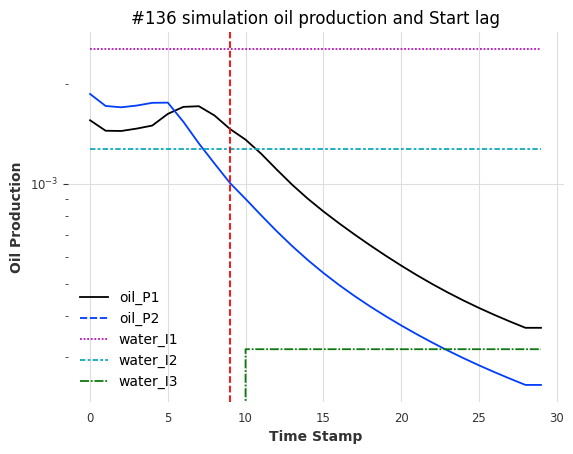

In [ ]:
%matplotlib inline
from time import sleep
total_sim_num = 136

for i in range(1, total_sim_num+1):
    ax = plot_simulation(wide_df, i)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    sleep(1)
    plt.close()

## Feature Preprocessing

In [ ]:
# create I3_start_wait_time feature
def convert_start_lag_feature(df):
    df = df.copy()
    df['I3_start_wait_time'] = df['start_lag'] - df.index
    return df.drop(['start_lag'], axis=1)

def convert_coef_feature(df):
    df = df.copy()
    df['coef'] = df['coef_P1']
    return df.drop(['coef_P1', 'coef_P2', 'coef_I1', 'coef_I2', 'coef_I3'], axis=1)

wide_df = convert_start_lag_feature(wide_df)
wide_df = convert_coef_feature(wide_df)

In [ ]:
# # Define the forecast horizon
# forecast_horizon = 3  # 3 steps

# # Set the split point
# split_date = wide_df.index[-forecast_horizon]

In [ ]:
# from sklearn.model_selection import TimeSeriesSplit

# # y consist of triplets of data, that is last 3 days of every simulation oil values

# X = wide_df.query("index < @split_date")
# y1 = wide_df.query("index >= @split_date")['oil_P1']
# y2 = wide_df.query("index >= @split_date")['oil_P2']

In [ ]:
wide_df.describe()

,oil_P1,liquid_P1,water_P1,oil_P2,liquid_P2,water_P2,oil_I1,liquid_I1,bhp_I1,water_I1,oil_I2,liquid_I2,bhp_I2,water_I2,oil_I3,liquid_I3,bhp_I3,water_I3,I3_start_wait_time,coef
count,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0
mean,-0.001023,-0.002024,-0.001001,-0.000825,-0.002552,-0.001727,0.0,0.002542,39307426.986941,0.002542,0.0,0.001271,34577365.968647,0.001271,0.0,0.000827,20439336.96127,0.000827,-2.852941,0.375
std,0.000527,0.000445,0.000804,0.000563,0.000609,0.001066,0.0,0.000004,3238509.429383,0.000004,0.0,0.000002,2878778.754484,0.000002,0.0,0.000895,17660157.795677,0.000895,11.245241,0.191531
min,-0.002742,-0.003233,-0.002844,-0.002261,-0.004109,-0.003566,0.0,0.002535,32885284.328368,0.002535,0.0,0.001268,29236039.36055,0.001268,0.0,0.0,0.0,0.0,-29.0,0.08
25%,-0.001526,-0.002364,-0.001668,-0.001339,-0.003029,-0.002567,0.0,0.002539,36726924.875614,0.002539,0.0,0.001269,32192999.266509,0.001269,0.0,0.0,0.0,0.0,-11.0,0.23
50%,-0.000885,-0.001913,-0.001028,-0.000574,-0.002456,-0.001931,0.0,0.002542,39229650.291025,0.002542,0.0,0.001271,34385669.958661,0.001271,0.0,0.000634,30760126.340532,0.000634,-3.0,0.375
75%,-0.00053,-0.001636,-0.000008,-0.00035,-0.002121,-0.000878,0.0,0.002545,41331985.265051,0.002545,0.0,0.001272,36675753.030421,0.001272,0.0,0.001589,35608283.394727,0.001589,5.0,0.52
max,-0.000316,-0.001389,0.0,-0.000203,-0.001499,0.0,0.0,0.00255,52343770.978892,0.00255,0.0,0.001275,45327034.029274,0.001275,0.0,0.00255,48934476.11132,0.00255,24.0,0.67


# Test Train Split and Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


X = wide_df.drop(['oil_P1', 'oil_P2'], axis=1)
y = wide_df[['oil_P1', 'oil_P2']]

# better to fit_transform after separation on train and test, but as it is pretty complicated here, i will not do it there
scaler = StandardScaler()
X_trf = pd.DataFrame( data=scaler.fit_transform(X), columns = X.columns, index=X.index)
y_trf = pd.DataFrame( data=scaler.fit_transform(y), columns = y.columns, index=y.index)

wide_df_trf = X_trf
wide_df_trf['oil_P1'] = y_trf['oil_P1']
wide_df_trf['oil_P2'] = y_trf['oil_P2']



In [ ]:
from darts import TimeSeries

def split_df_on_experiments(df):
    ts_experiments = np.array_split(df, num_of_experiments)
    split_date = 26
    
    ts_train = []
    ts_val1 = []
    ts_val2 = []
    for ts in ts_experiments:
        X = ts.query("index <= @split_date")
        y1 = ts.query("index > @split_date")['oil_P1']
        y2 = ts.query("index > @split_date")['oil_P2']
        
        ts_train.append(TimeSeries.from_dataframe(X)) 
        ts_val1.append(TimeSeries.from_series(y1)) 
        ts_val2.append(TimeSeries.from_series(y2))
    return ts_train, ts_val1, ts_val2

def apply_on_each(series_sequence, func):
    new_series_list = []
    for ts in series_sequence:
        new_series_list.append(func(ts))
    return new_series_list
    
# ts_train, ts_val1, ts_val2 are vectors of time_series, where every element of a vector represents one experiment
# type is darts.TimeSeries
train_trf, val1_trf, val2_trf = split_df_on_experiments(wide_df_trf)

def pl(train, val):
    if type(train) == list:
        train = train[0]
    if type(val) == list:
        val = val[0]

    train = TimeSeries.pd_dataframe(train)
    val = TimeSeries.pd_series(val)

    plt.figure(figsize=(8,4)) 
    plt.plot(train.index, train['oil_P1'], label='train')
    plt.plot(val.index, val, label='val')
    plt.show()

#Baseline darts Model

In [ ]:
from darts.models.forecasting.baselines import NaiveMean
from darts.metrics import mse
from typing import Sequence

def mse_stats(errors: list):
    avg_mse = np.mean(errors)
    stats = f"""
    Average MSE based on all experiments: {avg_mse}
    Standard deviation of MSE values: {np.std(errors).round(3)}
    MSE, for first 3 experiments: {[x.round(3) for x in errors[:3] ]}
    """
    return stats, avg_mse

def linear_model_global_mean_mse(train: Sequence[TimeSeries], P1_val: Sequence[TimeSeries], P2_val: Sequence[TimeSeries]):
    
    def fit_predict(val: TimeSeries, train: TimeSeries, well_index):
        model = NaiveMean()
        model.fit(train)
        pred = model.predict(n=3)[f'oil_P{well_index}']
        return mse(pred, val), pred

    errors_P1 = []
    errors_P2 = []
    pred_P1 = []
    pred_P2 = []
    for ts_index in tqdm(range(len(train))):
        mse_err, pred = fit_predict(val=P1_val[ts_index], train=train[ts_index], well_index=1)
        errors_P1.append( mse_err ), pred_P1.append(pred)
        mse_err, pred = fit_predict(val=P2_val[ts_index], train=train[ts_index], well_index=2)
        errors_P2.append( mse_err ), pred_P2.append(pred)
    
    return errors_P1, errors_P2, pred_P1, pred_P2


errors_P1, errors_P2, baseline_pred_P1, baseline_pred_P2 = linear_model_global_mean_mse(train_trf, val1_trf, val2_trf)
base_errs = [mse_stats(errors_P1)[0], mse_stats(errors_P2)[0]]

print(base_errs[0], '\n', base_errs[1])


<ipython-input-145-9ecea58e8ee1>:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ts_index in tqdm(range(len(train))):


  0%|          | 0/136 [00:00<?, ?it/s]


    Средний MSE ориентируясь по всем экспериментам: 1.8222190185813458
    Стандартное отклонение значений MSE: 0.438
    MSE, для первых 3 экспериментов: [1.29, 1.256, 1.62]
     
 
    Средний MSE ориентируясь по всем экспериментам: 1.2527325275682724
    Стандартное отклонение значений MSE: 0.158
    MSE, для первых 3 экспериментов: [1.201, 1.069, 1.129]
    


# RNN Model

In [ ]:
from darts.models import BlockRNNModel

FC_N = 3

def RNN_pipeline(train_trf: Sequence[TimeSeries], val_trf: Sequence[TimeSeries], 
                 well_index: int, n_epochs=10, params=None):
    """
    Creates a BlockRNN model, collects the target time series, and trains the model, then obtains an estimate of the model through MSE metric. 
    Sequences of time series train period and validation period, and well_index = 1 || 2 (P1, P2) are expected as input.

    train_trf: Sequence multivariate time series
    val_trf: sequence univariate time series for given well
    well_index: index of a production well
    parameter_grid: grid for tuning
    """
    
    def get_P1_target_col(ts: TimeSeries):
        df = TimeSeries.pd_dataframe(ts)
        y = df['oil_P1']
        return TimeSeries.from_series(y)

    def get_P2_target_col(ts: TimeSeries):
        df = TimeSeries.pd_dataframe(ts)
        y = df['oil_P2']
        return TimeSeries.from_series(y)
    
    if well_index == 1:
        get_target_col = get_P1_target_col
    elif well_index == 2:
        get_target_col = get_P2_target_col
    else:
        raise Exception('Incorrect well_index', well_index)

    target_train = apply_on_each(train_trf, get_target_col)

    if not params:
        # default model
        model_RNN = BlockRNNModel(
            input_chunk_length=6,
            output_chunk_length=3,
            hidden_dim=25,
            batch_size=16,
            n_epochs=n_epochs,
            dropout=0,
            optimizer_kwargs={'lr': 1e-3},
            log_tensorboard=True,
            random_state=42,
            force_reset=True)
    else:
        # create model from params
        p = params
        model_RNN = BlockRNNModel(
            input_chunk_length=6,
            output_chunk_length=3,
            hidden_dim=p['hidden_dim'],
            batch_size=p['batch_size'],
            n_epochs=p['n_epochs'],
            dropout=p['dropout'],
            optimizer_kwargs=p['optimizer_kwargs'],
            n_rnn_layers=p['n_rnn_layers'],
            log_tensorboard=True,
            random_state=42,
            force_reset=True)
        
        
    model_RNN.fit(series=target_train,
            past_covariates=train_trf,
            val_past_covariates=train_trf,
            verbose=True) # !!! 


    pred = model_RNN.predict(series=target_train, n=FC_N, past_covariates=train_trf) 
    mse_errs = mse(actual_series=val_trf, pred_series=pred)
    stats, avg_mse = mse_stats(mse_errs)

    result = {'model': model_RNN, 'preds': pred , 'mse_errs': mse_errs, 'mse_stats': stats, 'mse': avg_mse}
    return result

In [ ]:
def plot_model_forecast(ts_train: Sequence[TimeSeries], preds: Sequence[TimeSeries],
                        ts_val: Sequence[TimeSeries], experiment_num, well_index, msg):
    """
    ts_train: Sequence multivariate TimeSeries
    ts_val: Sequence univariate TimeSeries
    pred: Sequence univariate TimeSeries
    """
    plt.figure()

    sim_df = TimeSeries.pd_dataframe( ts_train[experiment_num] )
    val = TimeSeries.pd_series( ts_val[experiment_num] )
    pred = TimeSeries.pd_series( preds[experiment_num] )

    plt.figure(figsize=(8,4)) 
    plt.plot(sim_df.index, sim_df['oil_P1'], label=f'Train data') 
    plt.plot(val.index, val, label='Validation data')
    plt.plot(pred.index, pred, label='Forecasted data') 
    plt.legend(loc='best') 
    plt.title(f'Scaled Oil Production of Well #{well_index}: {msg}')
    plt.show()

    return ax

In [ ]:
result_p1 = RNN_pipeline(train_trf, val1_trf, 1, n_epochs=10)
result_p2 = RNN_pipeline(train_trf, val2_trf, 2, n_epochs=10)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 1.2 K 
4 | fc            | Sequential       | 78    
---------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 1.2 K 
4 | fc            | Sequential       | 78    
---------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

## Even on the RNN model without tuned hyperparameters, we get a very good result: MSE metric is ~300 times smaller than on the baseline!

In [ ]:
print('Baseline:')
for stat in base_errs:
    print(stat)

print('\nRNN Model (Untuned):')
for r in (result_p1, result_p2):
    print(r['mse_stats'])

Baseline:

    Средний MSE ориентируясь по всем экспериментам: 1.8222190185813458
    Стандартное отклонение значений MSE: 0.438
    MSE, для первых 3 экспериментов: [1.29, 1.256, 1.62]
    

    Средний MSE ориентируясь по всем экспериментам: 1.2527325275682724
    Стандартное отклонение значений MSE: 0.158
    MSE, для первых 3 экспериментов: [1.201, 1.069, 1.129]
    

RNN Model (Untuned):

    Средний MSE ориентируясь по всем экспериментам: 0.0028397450590206784
    Стандартное отклонение значений MSE: 0.005
    MSE, для первых 3 экспериментов: [0.0, 0.0, 0.0]
    

    Средний MSE ориентируясь по всем экспериментам: 0.0016450574574604683
    Стандартное отклонение значений MSE: 0.002
    MSE, для первых 3 экспериментов: [0.0, 0.001, 0.0]
    


## Plots of baseline and RNN models

<Figure size 640x480 with 0 Axes>

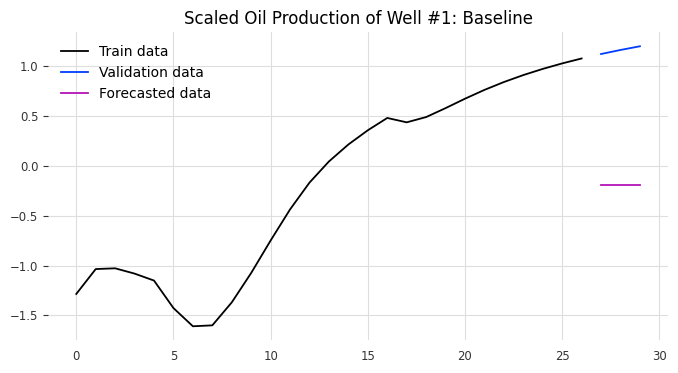

<Figure size 640x480 with 0 Axes>

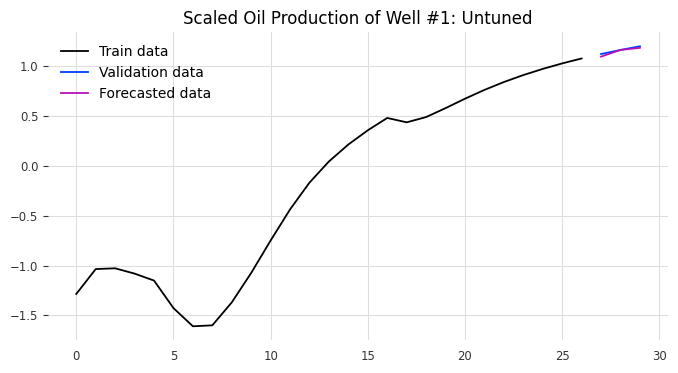

<Figure size 640x480 with 0 Axes>

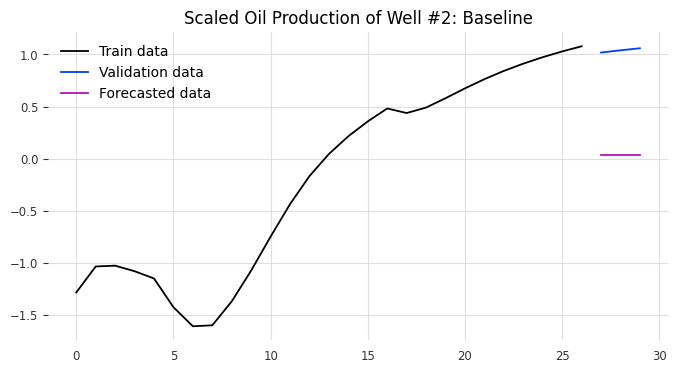

<Figure size 640x480 with 0 Axes>

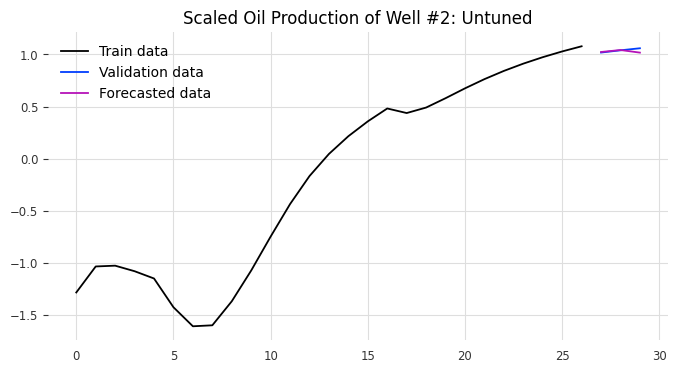

In [ ]:
from random import randrange
experiment_num = randrange(0, 139)

ax = plot_model_forecast(train_trf, baseline_pred_P1, val1_trf, experiment_num, well_index=1, msg='Baseline')
ax = plot_model_forecast(train_trf, result_p1['preds'], val1_trf, experiment_num, well_index=1, msg='Untuned')

ax = plot_model_forecast(train_trf, baseline_pred_P2, val2_trf, experiment_num, well_index=2, msg='Baseline')
ax = plot_model_forecast(train_trf, result_p2['preds'], val2_trf, experiment_num, well_index=2, msg='Untuned')

## Hyperparameter tuning

In [ ]:
from typing import Dict
import itertools

def search_grid_RNN(parameter_grid: Dict, train_trf: Sequence[TimeSeries], 
                    val_trf: Sequence[TimeSeries], well_index: int,):
    def product_dict(**kwargs):
        keys = kwargs.keys()
        for instance in itertools.product(*kwargs.values()):
            yield dict(zip(keys, instance))

    best_model_info = {'model': None, 'mse': np.inf, 'params': None}
    for params in product_dict(**parameter_grid):
        res = RNN_pipeline(train_trf, val_trf, well_index, params=params)
        model, mse, pred = res['model'], res['mse'], res['preds']
        print(f"""
        MSE: {mse}
        params: {params}
        Best model?: {'Yes' if mse < best_model_info['mse'] else 'No'}
        """)

        if mse < best_model_info['mse']:
            best_model_info['model'] = model
            best_model_info['mse'] = mse
            best_model_info['params'] = params
            best_model_info['preds'] = pred
    return best_model_info

In [ ]:
parameter_grid = {
    'input_chunk_length': [12],
    'output_chunk_length': [3],
    'hidden_dim': [15, 25],
    'batch_size': [16],
    'n_epochs': [10, 20],
    'dropout': [0, 0.25],
    'optimizer_kwargs': [{'lr': 1e-4}, {'lr': 1e-3}],
    'n_rnn_layers': [1],
    'random_state': [42]
}

# get models and best parameters
result_p1_cv = search_grid_RNN(parameter_grid, train_trf, val1_trf, 1)
result_p2_cv = search_grid_RNN(parameter_grid, train_trf, val2_trf, 2)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 570   
4 | fc            | Sequential       | 48    
---------------------------------------------------
618       Trainable params
0         Non-trainable params
618       Total params
0.002     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]


        MSE: 0.017115258925242405
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 15, 'batch_size': 16, 'n_epochs': 10, 'dropout': 0, 'optimizer_kwargs': {'lr': 0.0001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: Yes
        


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 570   
4 | fc            | Sequential       | 48    
---------------------------------------------------
618       Trainable params
0         Non-trainable params
618       Total params
0.002     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]


        MSE: 0.0034077058315356247
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 15, 'batch_size': 16, 'n_epochs': 10, 'dropout': 0, 'optimizer_kwargs': {'lr': 0.001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: Yes
        


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | r

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]


        MSE: 0.017115258925242405
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 15, 'batch_size': 16, 'n_epochs': 10, 'dropout': 0.25, 'optimizer_kwargs': {'lr': 0.0001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: No
        


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | r

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]


        MSE: 0.0034077058315356247
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 15, 'batch_size': 16, 'n_epochs': 10, 'dropout': 0.25, 'optimizer_kwargs': {'lr': 0.001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: No
        


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 570   
4 | fc            | Sequential       | 48    
---------------------------------------------------
618       Trainable params
0         Non-trainable params
618       Total params
0.002     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]


        MSE: 0.008203342924480148
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 15, 'batch_size': 16, 'n_epochs': 20, 'dropout': 0, 'optimizer_kwargs': {'lr': 0.0001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: No
        


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 570   
4 | fc            | Sequential       | 48    
---------------------------------------------------
618       Trainable params
0         Non-trainable params
618       Total params
0.002     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]


        MSE: 0.0025696353945359575
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 15, 'batch_size': 16, 'n_epochs': 20, 'dropout': 0, 'optimizer_kwargs': {'lr': 0.001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: Yes
        


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | r

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]


        MSE: 0.008203342924480148
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 15, 'batch_size': 16, 'n_epochs': 20, 'dropout': 0.25, 'optimizer_kwargs': {'lr': 0.0001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: No
        


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | r

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 1.2 K 
4 | fc            | Sequential       | 78    
---------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)



        MSE: 0.0025696353945359575
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 15, 'batch_size': 16, 'n_epochs': 20, 'dropout': 0.25, 'optimizer_kwargs': {'lr': 0.001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: No
        


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]


        MSE: 0.011216612194443545
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 25, 'batch_size': 16, 'n_epochs': 10, 'dropout': 0, 'optimizer_kwargs': {'lr': 0.0001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: No
        


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 1.2 K 
4 | fc            | Sequential       | 78    
---------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]


        MSE: 0.0028397450590206784
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 25, 'batch_size': 16, 'n_epochs': 10, 'dropout': 0, 'optimizer_kwargs': {'lr': 0.001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: No
        


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | r

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]


        MSE: 0.011216612194443545
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 25, 'batch_size': 16, 'n_epochs': 10, 'dropout': 0.25, 'optimizer_kwargs': {'lr': 0.0001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: No
        


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | r

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]


        MSE: 0.0028397450590206784
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 25, 'batch_size': 16, 'n_epochs': 10, 'dropout': 0.25, 'optimizer_kwargs': {'lr': 0.001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: No
        


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 1.2 K 
4 | fc            | Sequential       | 78    
---------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]


        MSE: 0.009207673595764874
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 25, 'batch_size': 16, 'n_epochs': 20, 'dropout': 0, 'optimizer_kwargs': {'lr': 0.0001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: No
        


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 1.2 K 
4 | fc            | Sequential       | 78    
---------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | r


        MSE: 0.004040624665690665
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 25, 'batch_size': 16, 'n_epochs': 20, 'dropout': 0, 'optimizer_kwargs': {'lr': 0.001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: No
        


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | r


        MSE: 0.009207673595764874
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 25, 'batch_size': 16, 'n_epochs': 20, 'dropout': 0.25, 'optimizer_kwargs': {'lr': 0.0001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: No
        


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]


        MSE: 0.004040624665690665
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 25, 'batch_size': 16, 'n_epochs': 20, 'dropout': 0.25, 'optimizer_kwargs': {'lr': 0.001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: No
        


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 570   
4 | fc            | Sequential       | 48    
---------------------------------------------------
618       Trainable params
0         Non-trainable params
618       Total params
0.002     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]


        MSE: 0.012152953629240832
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 15, 'batch_size': 16, 'n_epochs': 10, 'dropout': 0, 'optimizer_kwargs': {'lr': 0.0001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: Yes
        


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 570   
4 | fc            | Sequential       | 48    
---------------------------------------------------
618       Trainable params
0         Non-trainable params
618       Total params
0.002     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]


        MSE: 0.0010861125665263178
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 15, 'batch_size': 16, 'n_epochs': 10, 'dropout': 0, 'optimizer_kwargs': {'lr': 0.001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: Yes
        


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | r

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]


        MSE: 0.012152953629240832
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 15, 'batch_size': 16, 'n_epochs': 10, 'dropout': 0.25, 'optimizer_kwargs': {'lr': 0.0001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: No
        


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | r

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



        MSE: 0.0010861125665263178
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 15, 'batch_size': 16, 'n_epochs': 10, 'dropout': 0.25, 'optimizer_kwargs': {'lr': 0.001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: No
        


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 570   
4 | fc            | Sequential       | 48    
---------------------------------------------------
618       Trainable params
0         Non-trainable params
618       Total params
0.002     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]


        MSE: 0.004570501636084708
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 15, 'batch_size': 16, 'n_epochs': 20, 'dropout': 0, 'optimizer_kwargs': {'lr': 0.0001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: No
        


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 570   
4 | fc            | Sequential       | 48    
---------------------------------------------------
618       Trainable params
0         Non-trainable params
618       Total params
0.002     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]


        MSE: 0.00089703369033843
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 15, 'batch_size': 16, 'n_epochs': 20, 'dropout': 0, 'optimizer_kwargs': {'lr': 0.001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: Yes
        


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | r

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | r


        MSE: 0.004570501636084708
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 15, 'batch_size': 16, 'n_epochs': 20, 'dropout': 0.25, 'optimizer_kwargs': {'lr': 0.0001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: No
        


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]


        MSE: 0.00089703369033843
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 15, 'batch_size': 16, 'n_epochs': 20, 'dropout': 0.25, 'optimizer_kwargs': {'lr': 0.001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: No
        


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 1.2 K 
4 | fc            | Sequential       | 78    
---------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]


        MSE: 0.0035293821344472434
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 25, 'batch_size': 16, 'n_epochs': 10, 'dropout': 0, 'optimizer_kwargs': {'lr': 0.0001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: No
        


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 1.2 K 
4 | fc            | Sequential       | 78    
---------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]


        MSE: 0.0016450574574604683
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 25, 'batch_size': 16, 'n_epochs': 10, 'dropout': 0, 'optimizer_kwargs': {'lr': 0.001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: No
        


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | r

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]


        MSE: 0.0035293821344472434
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 25, 'batch_size': 16, 'n_epochs': 10, 'dropout': 0.25, 'optimizer_kwargs': {'lr': 0.0001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: No
        


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | r

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 1.2 K 
4 | fc            | Sequential       | 78    
---------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)



        MSE: 0.0016450574574604683
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 25, 'batch_size': 16, 'n_epochs': 10, 'dropout': 0.25, 'optimizer_kwargs': {'lr': 0.001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: No
        


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]


        MSE: 0.0016344070359515922
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 25, 'batch_size': 16, 'n_epochs': 20, 'dropout': 0, 'optimizer_kwargs': {'lr': 0.0001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: No
        


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 1.2 K 
4 | fc            | Sequential       | 78    
---------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]


        MSE: 0.0012087423640370779
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 25, 'batch_size': 16, 'n_epochs': 20, 'dropout': 0, 'optimizer_kwargs': {'lr': 0.001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: No
        


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | r

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]


        MSE: 0.0016344070359515922
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 25, 'batch_size': 16, 'n_epochs': 20, 'dropout': 0.25, 'optimizer_kwargs': {'lr': 0.0001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: No
        


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | r

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]


        MSE: 0.0012087423640370779
        params: {'input_chunk_length': 12, 'output_chunk_length': 3, 'hidden_dim': 25, 'batch_size': 16, 'n_epochs': 20, 'dropout': 0.25, 'optimizer_kwargs': {'lr': 0.001}, 'n_rnn_layers': 1, 'random_state': 42}
        Best model?: No
        


In [ ]:
print('Baseline:')
for stat in base_errs:
    print(stat)

model_p1_tuned = result_p1_cv['model']
tuned_p1_pred = result_p1_cv['preds']
print('P1 Tuned Model MSE: ',result_p1_cv['mse'])
model_p2_tuned = result_p2_cv['model']
tuned_p2_pred = result_p1_cv['preds']
print('P2 Tuned Model MSE: ',result_p2_cv['mse'])

Baseline:

    Средний MSE ориентируясь по всем экспериментам: 1.8222190185813458
    Стандартное отклонение значений MSE: 0.438
    MSE, для первых 3 экспериментов: [1.29, 1.256, 1.62]
    

    Средний MSE ориентируясь по всем экспериментам: 1.2527325275682724
    Стандартное отклонение значений MSE: 0.158
    MSE, для первых 3 экспериментов: [1.201, 1.069, 1.129]
    
P1 Tuned Model MSE:  0.0025696353945359575
P2 Tuned Model MSE:  0.00089703369033843


## So by tuning we got such results 

Number of experiment: #29


<Figure size 640x480 with 0 Axes>

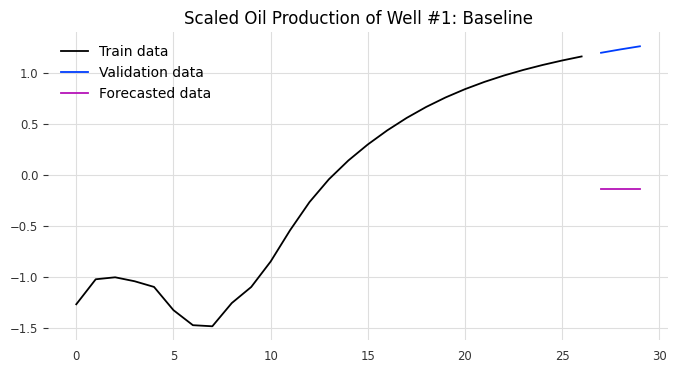

<Figure size 640x480 with 0 Axes>

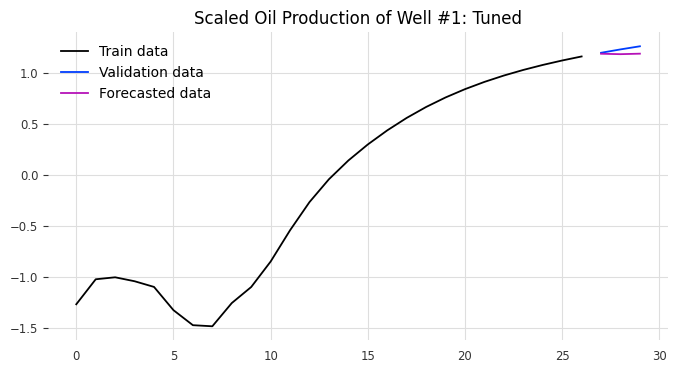

<Figure size 640x480 with 0 Axes>

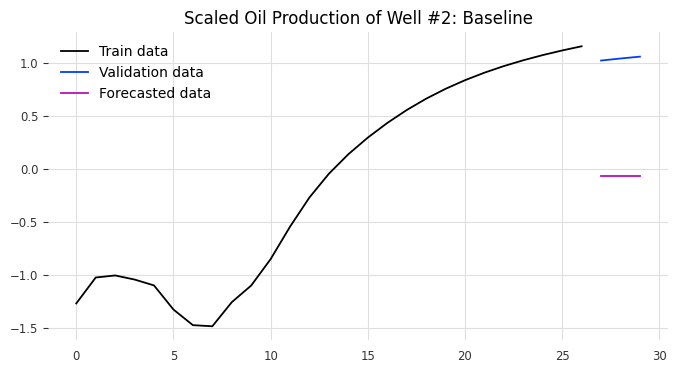

<Figure size 640x480 with 0 Axes>

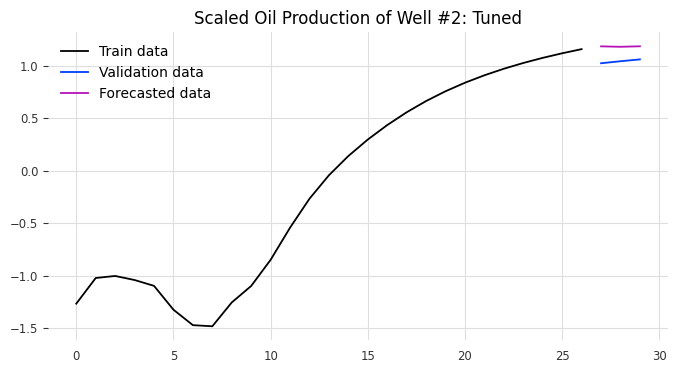

In [ ]:
from random import randrange
experiment_num = randrange(0, 139)

print(f"Number of experiment: #{experiment_num}")
ax = plot_model_forecast(train_trf, baseline_pred_P1, val1_trf, experiment_num, well_index=1, msg='Baseline')
ax = plot_model_forecast(train_trf, tuned_p1_pred, val1_trf, experiment_num, well_index=1, msg='Tuned')

ax = plot_model_forecast(train_trf, baseline_pred_P2, val2_trf, experiment_num, well_index=2, msg='Baseline')
ax = plot_model_forecast(train_trf, tuned_p2_pred, val2_trf, experiment_num, well_index=2, msg='Tuned')

## Ways to enhance model's performance:
1) Explore LSTM neural network approach to this task <br>
2) Apply geostatistical methods <br>
3) Expand simulations data to include several timestamps, at which I3 starts working <br>
4) Work on doing fit_transform for y_train and transform for y_test, to not give distribution details to the model.<br>
5) Make a bigger neural network (more hidden layers / higher hidden dimension / more rnn layers)

## Conclusion
Here a block RNN model was used, as neural networks generally perform really well on multi-experiment data. Such models as RNN capture how events are connected due to their ordering in time. I started with a baseline naive approach, which was taking the mean value for every experiment, and then used **RNN** to improve my model's **performance** in **900x** and **1500x** times for Producer Well #1 and Production Well #2 accordingly (according to MSE).